In [24]:
# Define the ticker list
import pandas as pd
tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP']




In [25]:
# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2015-1-1')['Adj Close']


[*********************100%%**********************]  6 of 6 completed


In [26]:
# Print first 5 rows of the data
print(data.head())

Ticker           AAPL        AXP          BA         IBM         MU        WMT
Date                                                                          
2015-01-02  24.402172  80.532135  113.657211  102.338928  34.099125  23.560392
2015-01-05  23.714716  78.402405  112.870049  100.728638  33.147301  23.491827
2015-01-06  23.716957  76.731506  111.540642   98.556313  32.254341  23.672850
2015-01-07  24.049519  78.407341  113.272377   97.912201  31.498764  24.300940
2015-01-08  24.973551  79.518776  115.275253  100.040314  33.039349  24.813843


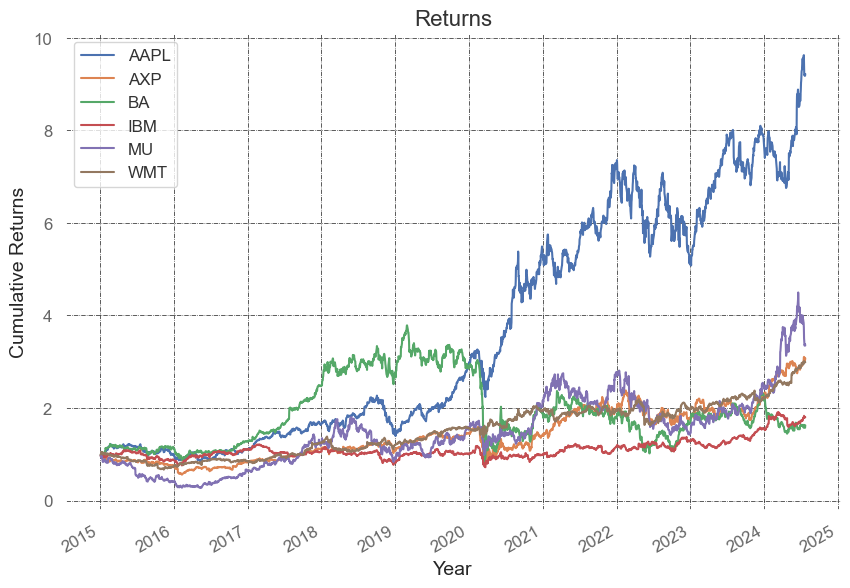

In [27]:
import matplotlib.pyplot as plt
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

Kurtosis of AAPL Daily Returns: 5.235

Kurtosis of WMT Daily Returns: 15.982

Kurtosis of IBM Daily Returns: 10.100

Kurtosis of MU Daily Returns: 3.161

Kurtosis of BA Daily Returns: 16.693

Kurtosis of AXP Daily Returns: 22.492



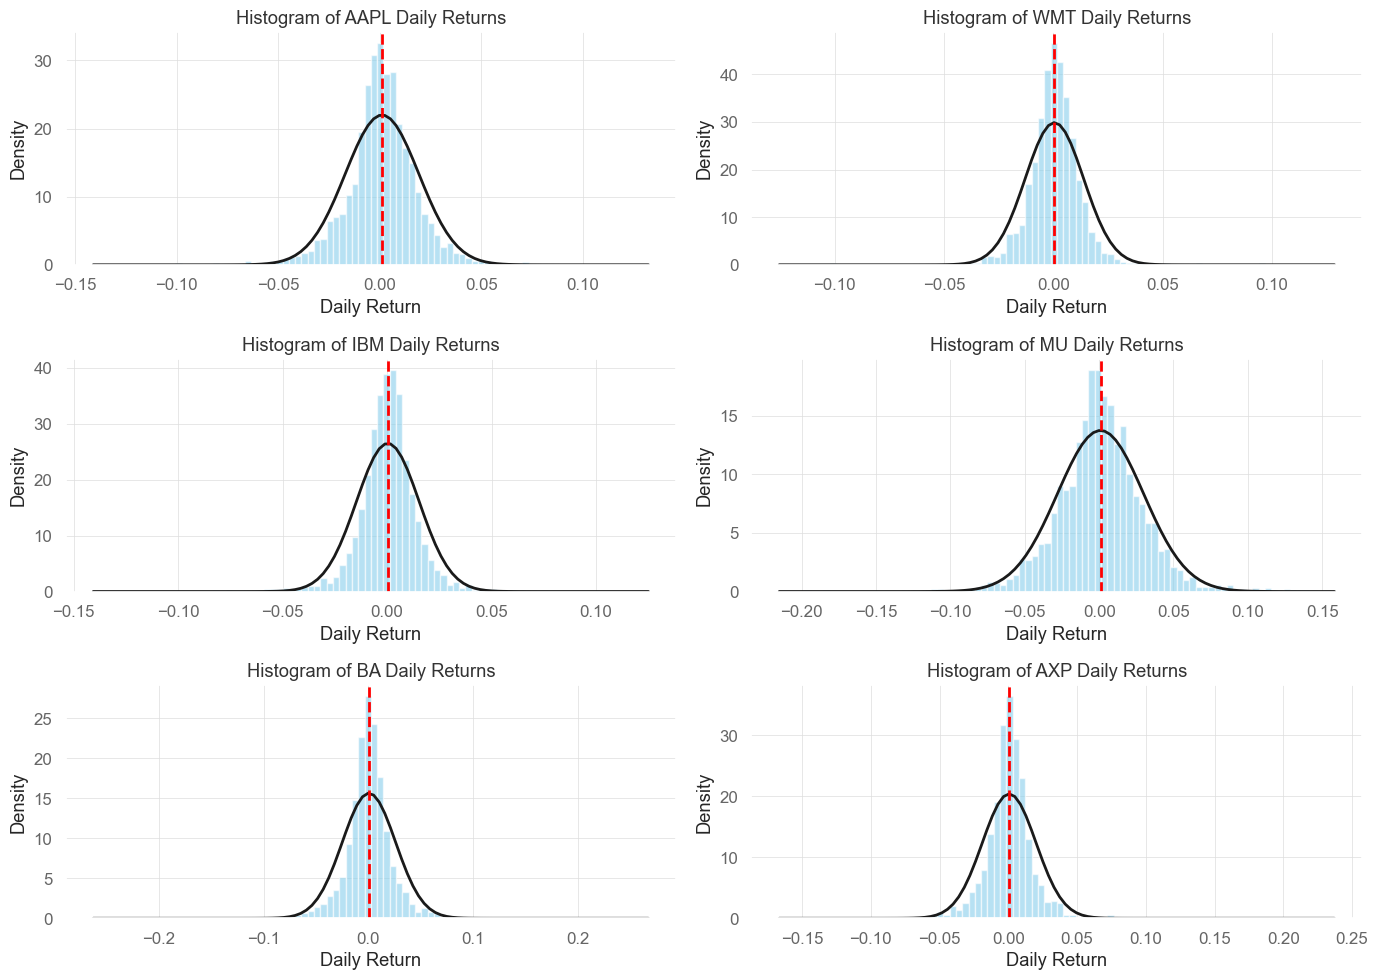

Standard Deviations of Daily Returns:
Ticker
AAPL    0.018143
AXP     0.019556
BA      0.025531
IBM     0.015045
MU      0.029023
WMT     0.013360
dtype: float64


In [28]:

from scipy.stats import norm , kurtosis
import numpy as np
import seaborn as sns


# Plot histograms of daily returns with normal distribution
returns = data.pct_change().dropna()

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()


for i, ticker in enumerate(tickers_list):
    # Calculate mean and standard deviation
    mu, std = norm.fit(returns[ticker])
    
   # Calculate kurtosis
    k = kurtosis(returns[ticker])
    print(f'Kurtosis of {ticker} Daily Returns: {k:.3f}\n')
    
    # Plot histogram
    axes[i].hist(returns[ticker], bins=80, density=True, alpha=0.6, color='skyblue')
    
    
    # Plot the normal distribution
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2)
    
    # Plot the mean as a red line
    axes[i].axvline(mu, color='red', linestyle='dashed', linewidth=2)
    
    # Set titles and labels
    axes[i].set_title(f'Histogram of {ticker} Daily Returns')
    axes[i].set_xlabel('Daily Return')
    axes[i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print standard deviation of daily returns
std_devs = returns.std()
print("Standard Deviations of Daily Returns:")
print(std_devs)



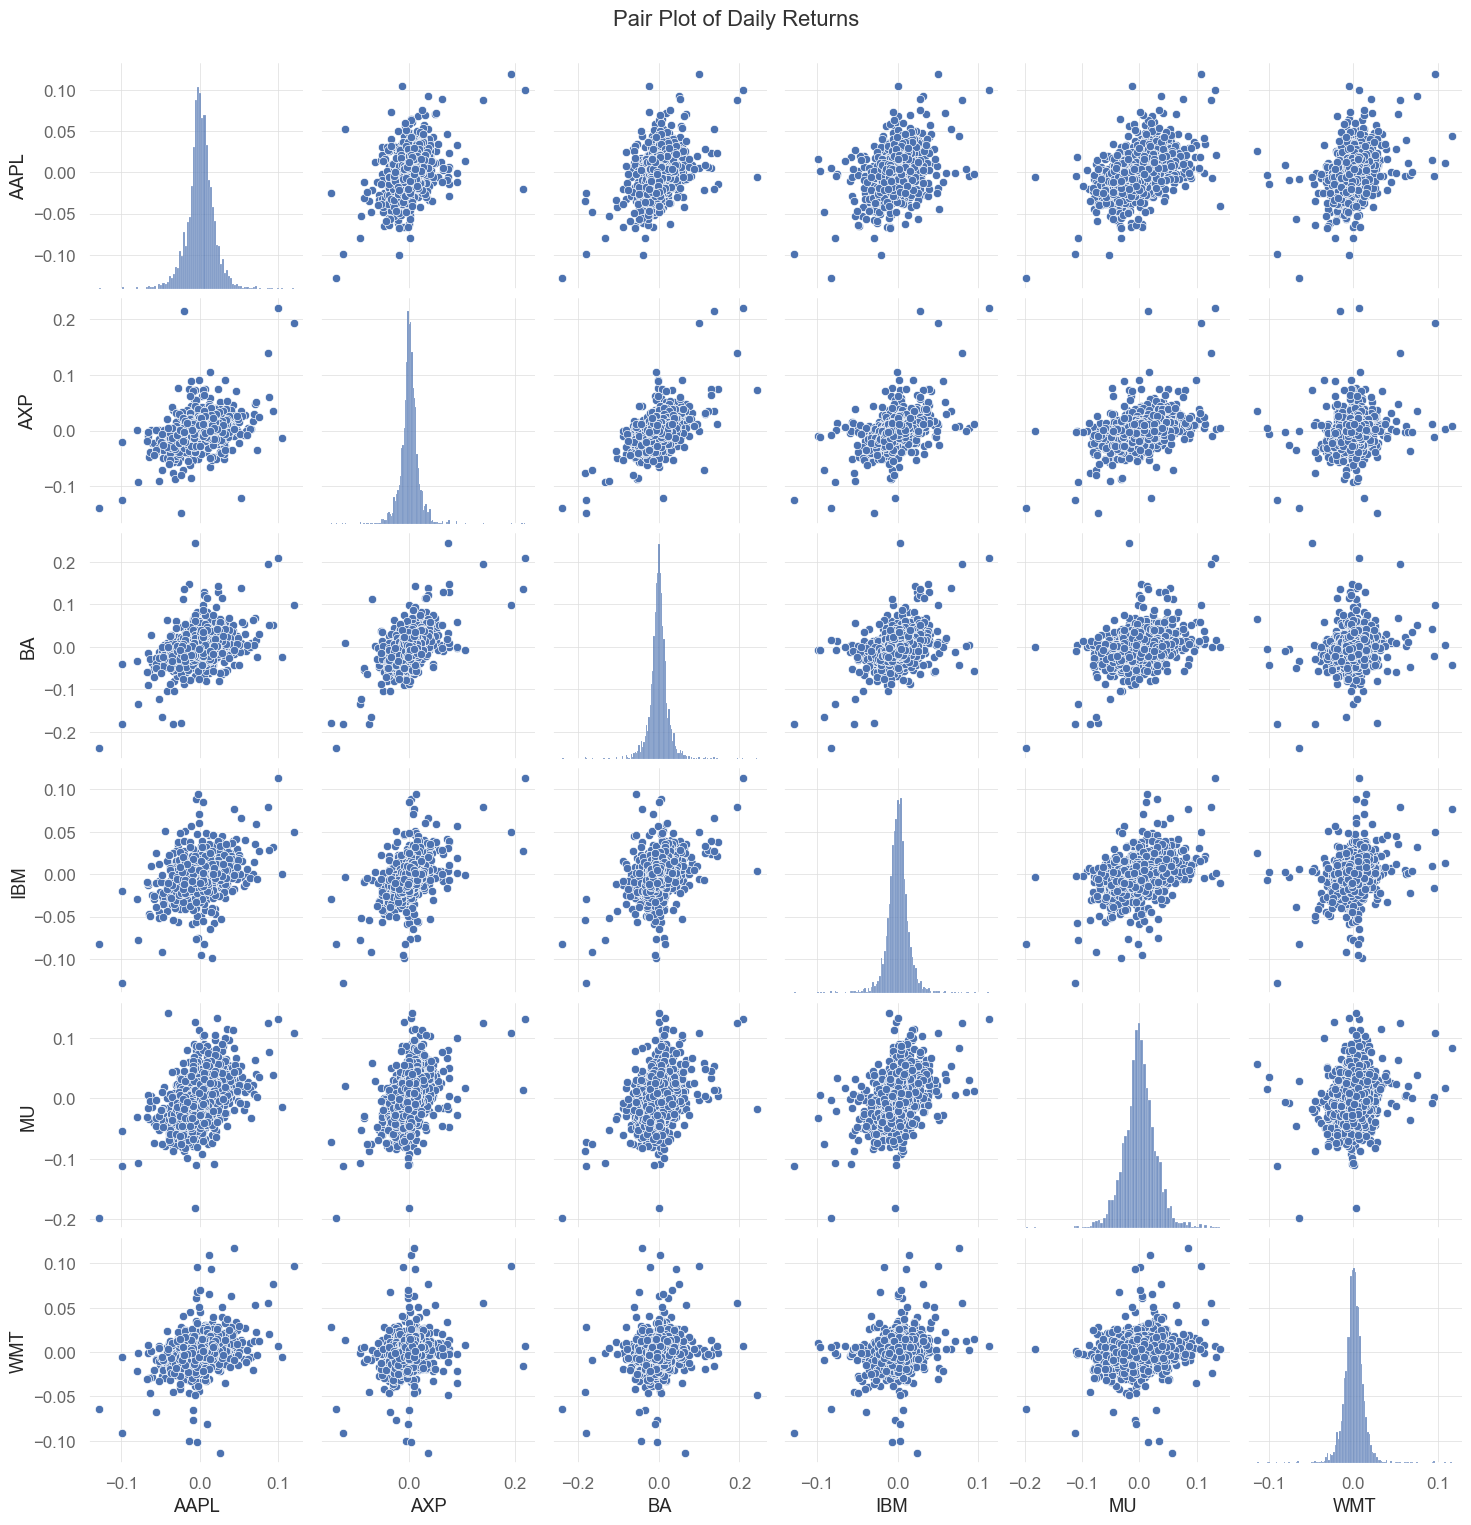

In [29]:
# Pair plots of daily returns
sns.pairplot(returns)
plt.suptitle('Pair Plot of Daily Returns', y=1.02)
plt.show()

In [30]:
# Correlation matrix
correlation_matrix = returns.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
Ticker      AAPL       AXP        BA       IBM        MU       WMT
Ticker                                                            
AAPL    1.000000  0.418074  0.401272  0.404345  0.459246  0.316487
AXP     0.418074  1.000000  0.583913  0.504837  0.421329  0.219495
BA      0.401272  0.583913  1.000000  0.426939  0.374164  0.183050
IBM     0.404345  0.504837  0.426939  1.000000  0.394211  0.297943
MU      0.459246  0.421329  0.374164  0.394211  1.000000  0.177290
WMT     0.316487  0.219495  0.183050  0.297943  0.177290  1.000000


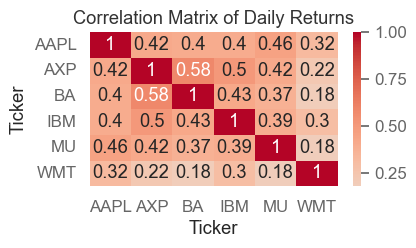

In [35]:
# Plot the correlation matrix
plt.figure(figsize=(4, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

Beta and Alpha

Beta and Alpha are two key metrics used in finance to evaluate the performance of a stock relative to the overall market. Beta is a measure of a stock's volatility compared to the market. A Beta of 1 means that the stock is as volatile as the market, a Beta greater than 1 indicates higher volatility than the market, and a Beta less than 1 suggests lower volatility.


Alpha, on the other hand, is a measurement of a stock's excess return relative to its expected performance based on its Beta. A positive Alpha indicates that a stock has outperformed its expected performance based on its Beta, while a negative Alpha suggests underperformance. By analyzing the Beta and Alpha values of stocks, investors can get a better understanding of the risk and potential returns of the stock compared to the market, and make informed investment decisions accordingly.


To determine Beta and Alpha, we require data from the SP500, which acts as the benchmark, to fit a linear regression model between the stocks and the index. This will enable us to extract the Beta and Alpha values of the stocks.

In [32]:
!pip install quantstats

In [69]:

import quantstats as qs
import ta
import statsmodels.api as sm
tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP']

market_index_ticker = '^GSPC'  # S&P 500 index
data = yf.download(tickers_list + [market_index_ticker], start='2014-01-01', end='2024-01-01')['Adj Close']

## Calculate daily returns
returns = data.pct_change().dropna()

# Separate stock returns and market returns
stock_returns = returns[tickers_list]
market_returns = returns[market_index_ticker]

# Assume a risk-free rate of 3% per annum (approximately 0.03/252 per day)
risk_free_rate = 0.03 / 252

# Calculate beta for each stock using linear regression
betas = {}
for ticker in tickers_list:
    X = market_returns
    y = stock_returns[ticker]
    X = sm.add_constant(X)  # Add a constant term for the intercept
    model = sm.OLS(y, X).fit()
    betas[ticker] = model.params[1]  # The beta is the coefficient of the market returns

# Calculate expected returns using CAPM
market_premium = market_returns.mean() - risk_free_rate
expected_returns = {}
for ticker in tickers_list:
    expected_returns[ticker] = risk_free_rate + betas[ticker] * market_premium

# Calculate Sharpe Ratio for each stock
sharpe_ratios = {}
for ticker in tickers_list:
    excess_return = stock_returns[ticker].mean() - risk_free_rate
    sharpe_ratios[ticker] = excess_return / stock_returns[ticker].std()
print("Betas:", betas)
print("\n")
print("Expected Returns:", expected_returns)
print("\n")
print("Sharpe Ratios:", sharpe_ratios)
print("\n")


[*********************100%%**********************]  7 of 7 completed


Betas: {'AAPL': 1.1899101039696944, 'WMT': 0.5232135946785008, 'IBM': 0.8367202066125587, 'MU': 1.5377854325489906, 'BA': 1.3744373683193971, 'AXP': 1.2196456294053266}


Expected Returns: {'AAPL': 0.0005048091071386408, 'WMT': 0.00028867022683898183, 'IBM': 0.000390307129276056, 'MU': 0.0006175881347098868, 'BA': 0.0005646317036956658, 'AXP': 0.0005144491803701814}


Sharpe Ratios: {'AAPL': 0.055872498442456994, 'WMT': 0.024940885296810798, 'IBM': 0.008436343606499055, 'MU': 0.02946758349999186, 'BA': 0.020475667054662177, 'AXP': 0.021626278316867798}




In [ ]:
# Optimizing for maximal Sharpe ratio


This is for optimised risk as well as optimised weight

In [75]:
import yfinance as yf
import pandas as pd
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting

# Define the tickers and the time frame
tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP']
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download historical data
data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate expected annual returns
mu = expected_returns.mean_historical_return(data)

# Calculate the annualized sample covariance matrix of daily returns
S = risk_models.sample_cov(data)

# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Calculate the expected performance of the optimized portfolio
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

# Output the results
print("Optimal Weights:", cleaned_weights)
print("Expected Annual Return:", expected_annual_return)
print("Annual Volatility:", annual_volatility)
print("Sharpe Ratio:", sharpe_ratio)


[*********************100%%**********************]  6 of 6 completed


Optimal Weights: OrderedDict([('AAPL', 0.88817), ('AXP', 0.0), ('BA', 0.0), ('IBM', 0.0), ('MU', 0.0), ('WMT', 0.11183)])
Expected Annual Return: 0.2530271282832509
Annual Volatility: 0.26053504818380896
Sharpe Ratio: 0.8944175837672671



Optimized Portfolio Performance:



                    Strategy
------------------  ----------
Start Period        2014-01-03
End Period          2023-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   880.34%
CAGR﹪              17.09%

Sharpe              1.01
Prob. Sharpe Ratio  99.92%
Sortino             1.48
Sortino/√2          1.05
Omega               1.2

Max Drawdown        -35.0%
Longest DD Days     714

Gain/Pain Ratio     0.2
Gain/Pain (1M)      1.09

Payoff Ratio        1.04
Profit Factor       1.2
Common Sense Ratio  1.25
CPC Index           0.67
Tail Ratio          1.04
Outlier Win Ratio   3.85
Outlier Loss Ratio  3.97

MTD                 1.4%
3M                  11.18%
6M                  2.19%
YTD                 44.85%
1Y                  48.88%
3Y (ann.)           8.52%
5Y (ann.)           24.14%
10Y (ann.)          17.09%
All-time (ann.)     17.09%

Avg. Drawdown       -3.38%
Avg. Drawdown Days  28
Recovery Factor     7.49
Ulcer Index         0.11
Serenity Index      1.86


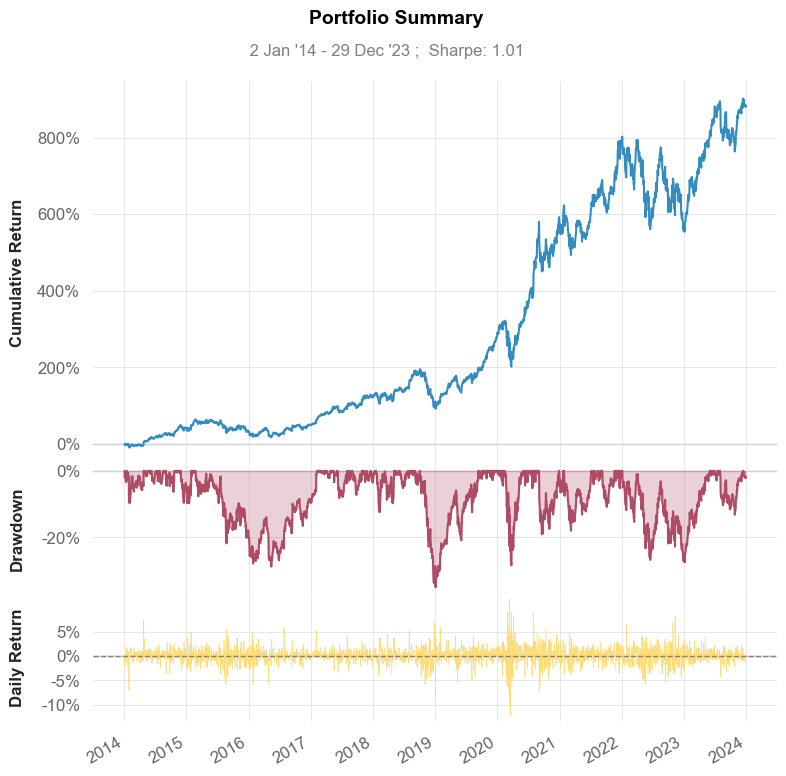

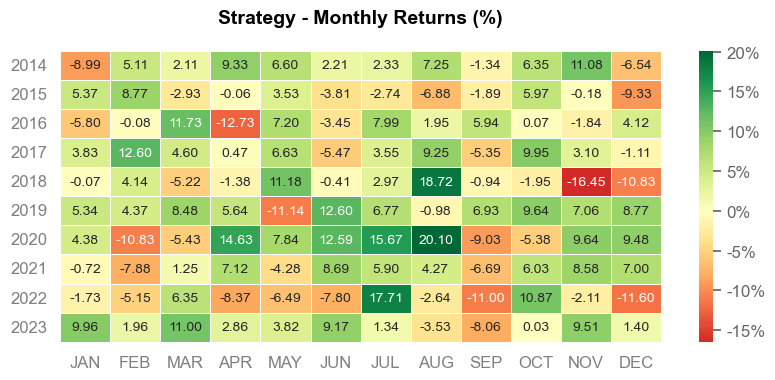


Original Portfolio Performance:



                    Strategy
------------------  ----------
Start Period        2014-01-03
End Period          2023-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   305.33%
CAGR﹪              10.15%

Sharpe              0.74
Prob. Sharpe Ratio  99.0%
Sortino             1.06
Sortino/√2          0.75
Omega               1.15

Max Drawdown        -40.83%
Longest DD Days     702

Gain/Pain Ratio     0.15
Gain/Pain (1M)      0.95

Payoff Ratio        0.98
Profit Factor       1.15
Common Sense Ratio  1.14
CPC Index           0.61
Tail Ratio          0.99
Outlier Win Ratio   3.7
Outlier Loss Ratio  3.77

MTD                 6.8%
3M                  19.84%
6M                  16.09%
YTD                 38.11%
1Y                  40.36%
3Y (ann.)           9.58%
5Y (ann.)           12.15%
10Y (ann.)          10.15%
All-time (ann.)     10.15%

Avg. Drawdown       -3.01%
Avg. Drawdown Days  27
Recovery Factor     4.03
Ulcer Index         0.11
Serenity Index      1.0

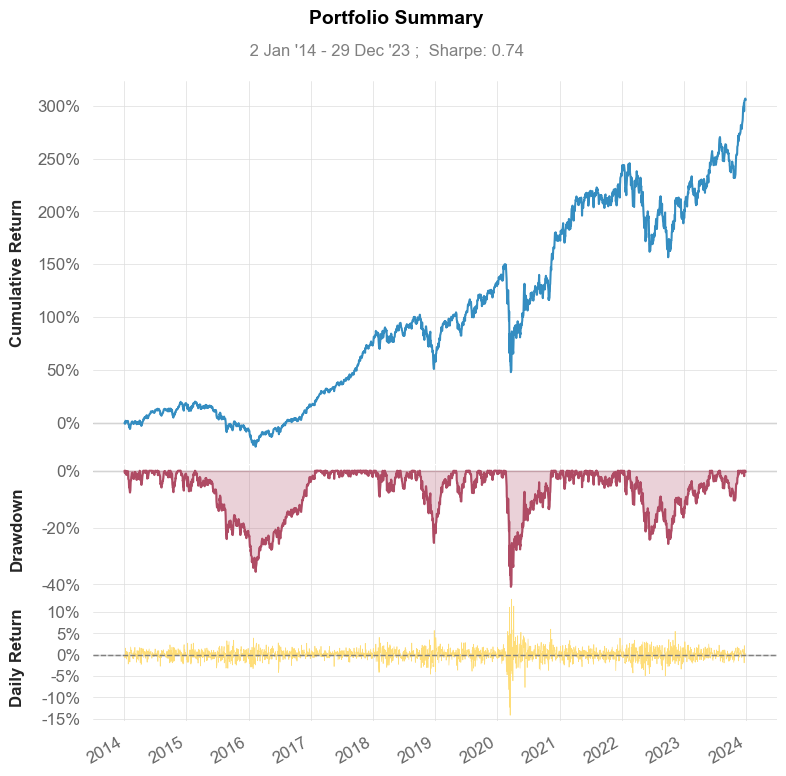

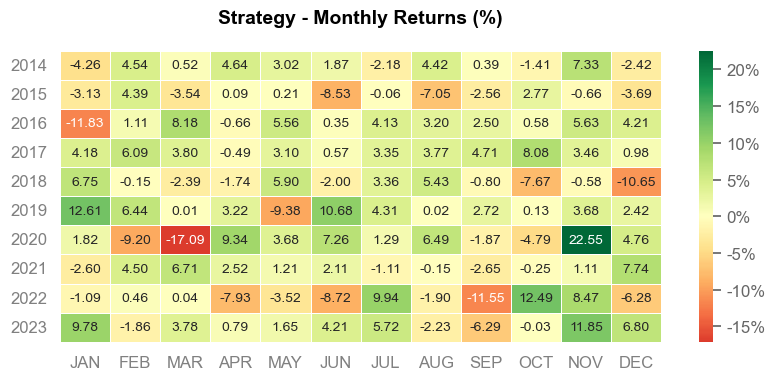

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['OPTIMIZED_PORTFOLIO_REPORT.HTML']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ORIGINAL_PORTFOLIO_REPORT.HTML']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/anisa/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/

In [84]:


# Convert weights to a pandas Series
optimized_weights = pd.Series(cleaned_weights)

# Calculate the returns of the optimized portfolio
optimized_portfolio_returns = (daily_returns * optimized_weights).sum(axis=1)

# Calculate the returns of the original portfolio (equal weights for simplicity)
equal_weights = pd.Series([1/len(tickers_list)]*len(tickers_list), index=tickers_list)
original_portfolio_returns = (daily_returns * equal_weights).sum(axis=1)

# Generate performance reports using Quantstats
qs.extend_pandas()

print("\nOptimized Portfolio Performance:\n")
qs.reports.basic(optimized_portfolio_returns)

print("\nOriginal Portfolio Performance:\n")
qs.reports.basic(original_portfolio_returns)

# Save performance reports as HTML
qs.reports.html(optimized_portfolio_returns, "optimized_portfolio_report.html")
qs.reports.html(original_portfolio_returns, "original_portfolio_report.html")



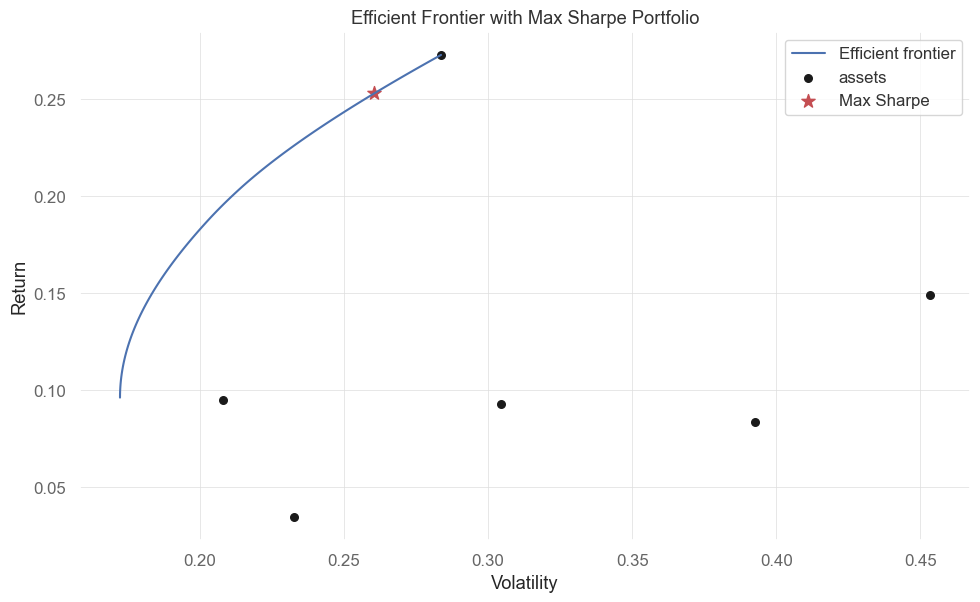

In [90]:
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting
# Plotting the Efficient Frontier
fig, ax = plt.subplots()

# Create a new EfficientFrontier instance for plotting
ef_for_plotting = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)

# Find the tangency portfolio
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()

# Plot the optimal portfolio
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe" )#max_sr_vol, max_sr_ret,c='red', s=50, edgecolors= 'black')

# Add labels and title
plt.title("Efficient Frontier with Max Sharpe Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()
